# Warsztaty badawcze - Projekt KM1
## Katarzyna Solawa, Jakub Jung, Aleksander Malinowski


# Research problem
As a research problem, we chose Challenge 2 (9 circles), from the article:

H. Müller & A. Holzinger. **Kandinsky Patterns**. Artificial Intelligence, 300, 103546. 2021. URL: https://doi.org/10.1016/j.artint.2021.103546.

Our target is to train a NN to classify Kandinsky Figures according to ground truth (rule that define the pattern).
We don't know what is the ground truth, so next we want to explain Kandinsky Patter using natural language by explaining our trained model.

#### **Ground truth**
![alt text](https://images.deepai.org/converted-papers/1906.00657/images/Challenge-2-TRUE.png "Ground truth")

#### **False**
![alt text](https://images.deepai.org/converted-papers/1906.00657/images/Challenge-2-FALSE.png "False")

#### **COUNTERFACTUAL**
![alt text](https://images.deepai.org/converted-papers/1906.00657/images/Challenge-2-COUNTERFACTUAL.png "COUNTERFACTUAL")






# Data

Data size:
* 1000 counterfactual;
* 1000 false;
* 1000 true;

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from  torchvision.datasets import ImageFolder 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
!git clone https://github.com/human-centered-ai-lab/dat-kandinsky-patterns.git

Cloning into 'dat-kandinsky-patterns'...
remote: Enumerating objects: 22535, done.
remote: Total 22535 (delta 0), reused 0 (delta 0), pack-reused 22535
Receiving objects: 100% (22535/22535), 396.91 MiB | 30.38 MiB/s, done.
Resolving deltas: 100% (357/357), done.
Checking out files: 100% (11253/11253), done.


In [ ]:


transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize(224),
      transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
!mkdir bez_cf

In [ ]:
!cp -r /content/dat-kandinsky-patterns/challenge-nr-2/counterfactual/. /content/

In [ ]:
!cp -r /content/dat-kandinsky-patterns/challenge-nr-2/true ./bez_cf

In [ ]:
!cp -r /content/dat-kandinsky-patterns/challenge-nr-2/false ./bez_cf

In [ ]:
!rename 's/^/cf_/' *.png

In [ ]:
!cp -a ./*.png /content/bez_cf/false/

In [ ]:
!ls /content/bez_cf/false/ | wc -l

2000


In [ ]:
data = ImageFolder('/content/bez_cf', transform = transform)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

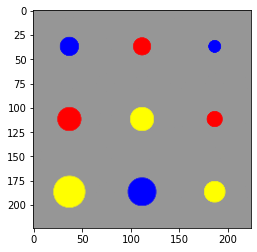

In [ ]:
imshow(torchvision.utils.make_grid(data[2000][0]))

## Split with even class size

In [ ]:
cf = torch.utils.data.Subset(data, list(range(1000)))
false = torch.utils.data.Subset(data, list(range(1000,2000)))
true = torch.utils.data.Subset(data, list(range(2000,3000)))

In [ ]:
train_cf, test_cf = torch.utils.data.random_split(cf, [800, 200])
train_false, test_false = torch.utils.data.random_split(cf, [800, 200])
train_true, test_true = torch.utils.data.random_split(cf, [800, 200])

In [ ]:
train = torch.utils.data.ConcatDataset([train_cf,train_false,train_true])
test = torch.utils.data.ConcatDataset([test_cf,test_false,test_true])

## Random split

In [ ]:
# train,test = torch.utils.data.random_split(data, [2400,600])


In [ ]:
l = [0,0]
# for i in range(2000,3000):
  #data[i]=data[i][0],0
for i in range(3000):
  l[data[i][1]]+=1

In [ ]:
print(l)

[2000, 1000, 0]


# Model

Using stratified labels distribution in data splitting

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class BasicBlock(torch.nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_planes,planes,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = torch.nn.Sequential(
              torch.nn.Conv2d(in_planes, self.expansion*planes,
                        kernel_size=1, stride=stride, bias=False),
              torch.nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.nn.functional.relu(out)
        return out
class ResNet(torch.nn.Module):
  def __init__(self,block, num_blocks, num_classes=2):
      super(ResNet,self).__init__()
      self.in_planes = 64
      self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
      self.bn1 = torch.nn.BatchNorm2d(64)
      self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
      self.layer2 = self._make_layer(block, 128, num_blocks[1],stride=2)
      self.layer3 = self._make_layer(block, 256, num_blocks[2],stride=2)
      self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
      self.linear = torch.nn.Linear(25088*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
      strides = [stride] + [1]*(num_blocks-1)
      layers = []
      for stride in strides:
          layers.append(block(self.in_planes, planes, stride))
          self.in_planes = planes * block.expansion
      return torch.nn.Sequential(*layers)
  def forward(self, x):
      out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
      out = self.layer1(out)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = torch.nn.functional.avg_pool2d(out, 4)
      out = out.view(out.size(0), -1)
      out = self.linear(out)
      return out

def ResNet14():
    return ResNet(BasicBlock, [1, 2, 2, 1])
def ResNet10():
    return ResNet(BasicBlock, [1,1,1,1])
def ResNet26():
  return ResNet(BasicBlock, [2,4,4,2])

def ResNet14Dropout():
  def append_dropout(model):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module)
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=0.1, inplace=True))
            setattr(model, name, new)
  model = ResNet14()
  append_dropout(model)
  return model

def ResNet26Dropout():
  def append_dropout(model):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module)
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=0.1, inplace=True))
            setattr(model, name, new)
  model = ResNet26()
  append_dropout(model)
  return model

def test_net(df):
    net = ResNet14()
    y = net(df)
    print(y)

In [ ]:
vc = [0,0,0]
for i in range(2400):
  vc[train.dataset[i][1]] += 1
print(vc)

[1000, 1000, 400]


In [ ]:
from collections  import OrderedDict
from IPython.display import clear_output
import pandas as pd
import time
if torch.cuda.is_available():  
  DEVICE = "cuda:0" 
else:  
  DEVICE = "cpu"
from collections import namedtuple
from itertools import product
import json

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.loader_test = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader, loader_test):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.loader_test = loader_test

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

    self.epoch_loss_test = 0
    self.epoch_num_correct_test = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    accuracy_test = self.epoch_num_correct_test / len(self.loader_test.dataset)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["accuracy_test"] = accuracy_test
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  def track_num_correct_test(self, preds, labels):
    self.epoch_num_correct_test += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

from collections import namedtuple
from itertools import product
def get_runs(params):
    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    return runs
epochs = 6


In [ ]:
# import gc
# m = RunManager()
# # DEVICE = "cpu"
# torch.cuda.empty_cache()
# for curr_net in [ResNet14,ResNet26,ResNet14Dropout,ResNet26Dropout]:
#   network = curr_net().to(DEVICE)
#   gc.collect()
#   torch.cuda.empty_cache()
#   loader_test = torch.utils.data.DataLoader(test, batch_size = 1,num_workers=4)
#   gc.collect()
#   torch.cuda.empty_cache()
#   loader = torch.utils.data.DataLoader(train, batch_size = 1,num_workers=4)
#   optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
#   m.begin_run(get_runs(OrderedDict(lr=[.01],batch_size=[1],shuffle=[True],))[0], network, loader, loader_test)
#   for epoch in range(epochs):
#         m.begin_epoch()
#         gc.collect()
#         torch.cuda.empty_cache()
#         for batch in loader_test:

#           images = batch[0].to(DEVICE)
#           labels = batch[1].to(DEVICE)
#           preds = network(images)
#           m.track_num_correct_test(preds, labels)
#           gc.collect()
#           torch.cuda.empty_cache()

#         gc.collect()
#         torch.cuda.empty_cache()
#         for batch in loader:
#           gc.collect()
#           torch.cuda.empty_cache()
#           images = batch[0].to(DEVICE)
#           labels = batch[1].to(DEVICE)
#           preds = network(images)
#           loss = F.cross_entropy(preds, labels)
#           #gc.collect()
#           optimizer.zero_grad()
#           #gc.collect()
#           loss.backward()
#           #gc.collect()
#           optimizer.step()
#           #gc.collect()
#           m.track_loss(loss)
#           m.track_num_correct(preds, labels)
#           #torch.cuda.empty_cache()
#         gc.collect()
#         torch.cuda.empty_cache()
#         m.end_epoch()
#         torch.cuda.empty_cache()
#   torch.cuda.empty_cache()
#   gc.collect()
#   m.end_run()

In [ ]:
import gc
device = DEVICE
def searching_function(params2, return_model=False, network = None):
  m = RunManager()

  # get all runs from params using RunBuilder class
  for run in RunBuilder.get_runs(params2):
    
    # if params changes, following line of code should reflect the changes too
    if network is None:
      network = ResNet10()
      # for param in network.parameters():
      #   param.required_grad = False
      # network.classifier = nn.Linear(1024, 100)
    # network.fc = nn.Sequential(nn.Flatten(),
    #     nn.Linear(network.fc.in_features, 128),
    #     nn.ReLU(),
    #     nn.Dropout(0.2),
    #     nn.Linear(128, 100))
    network.to(device)
    loader_test = torch.utils.data.DataLoader(test, batch_size = run.batch_size,shuffle=True,num_workers=4)
    loader = torch.utils.data.DataLoader(train, batch_size = run.batch_size,shuffle=True,num_workers=4)
    optimizer = torch.optim.Adam(network.parameters(), lr=0.01)

    m.begin_run(run, network, loader, loader_test)
    for epoch in range(epochs):
      
      m.begin_epoch()
      
      for batch in loader_test:

        images = batch[0].to(device)
        labels = batch[1].to(device)
        preds = network(images)
        m.track_num_correct_test(preds, labels)
        del images, labels, preds
        gc.collect()
        torch.cuda.empty_cache()


      for batch in loader:
        
        images = batch[0].to(device)
        labels = batch[1].to(device)
        preds = network(images).to(device)
        #print("po liczeniu predsow")
        loss = F.cross_entropy(preds, labels.long())
        #print("po ce")
        optimizer.zero_grad()
        #rint("po optim")
        loss.backward()
        #print("po loss")
        optimizer.step()
        #print("po stepie")
        m.track_loss(loss)
        m.track_num_correct(preds, labels)
        del images, labels, preds
        gc.collect()
        torch.cuda.empty_cache()

      m.end_epoch()
    m.end_run()

    # when all runs are done, save results to files
    if return_model == True:
      return network

Model - ResNetSmall

In [ ]:
params = OrderedDict(
    lr = [0.01],
    batch_size = [16],
    shuffle = [True],
)
trained_model = searching_function(params,return_model=True)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,0.004458,0.997083,0.316667,54.613561,54.613567,0.01,16,True
1,1,2,0.000000,1.000000,1.000000,54.295028,108.929324,0.01,16,True


KeyboardInterrupt: ignored

Data was correctly classified - no point in going further

# Articles
## 1. **Measuring abstract reasoning in neural network**
### David G.T. Barrett, Felix Hill, Adam Santoro, Ari S. Morcos, Timothy Lillicrap , 1807.04225 https://doi.org/10.48550/arXiv.1807.04225

The goal of this article was to understand whether and how neural networks are able to solve abstract reasoning, by studying procedurally generating matrices (IQ-tests like), using well-known (i.e. ResNet) and novel variants (WReN, Wild-ResNet) of neural networks architectures.

* Article contained lots of information useful for recreating the experiment, i.e.: clear info about network hyper-parameters and data generation.
* There are no tests on similar IQ-tests data, outside from the generated set. Authors only mentions: "It is highly unlikely that the model’s solutions
match those applied by successful humans" (taking Raven-style IQ tests).

* Advantage - implementing and using networks well matched to the problem of abstract reasoning.
* Disadvantage - data constrained by a small number of possible relations instantiated in finite sets of attributes and values.

## 2. **KANDINSKYPatterns - An experimental exploration environment for Pattern Analysis and Machine Intelligence**

### Andreas Holzinger, Anna Saranti, Heimo Mueller, 2103.00519 https://arxiv.org/abs/2103.00519

The article describes an experimental environment called KANDINSKYPatterns, which we'll be working on. It introduces the main goals and reasons of creating it.

* The important aspect mentioned in the article is `concept learning` - ability to emulate the human learning process and context-based recognition. 

* Article mentions various datasets, which have been used in Explainable Neural Networks development, e.g. VQA, CLEVR, CLEVERER

* Authors present various methods on solving `concept learning` problem. GNNs (Graph Neural Networks) were found to be a promising direction of further studies, due to their abilities of generalization. Combining various methods is also hoped to enhance model capabilities

Article contained useful explanations and reasoning behind the whole project, will probably be handy during the project development process.

## **Axiomatic Attribution for Deep Networks**

### Mukund Sundararajan, Ankur Taly, Qiqi Yan, 1703.01365 https://arxiv.org/abs/1703.01365

The goal of the article is to discuss methods for attributing the prediction of a neural network to the input features and to design a new method ("Integrated Gradient") satisfying two fundamental axioms - "Sensitivity" and "Implementation Invariance".

Method satisfies "Sensitivity" axiom if whenever input and baseline differ in one feature and have different predictions then that feature should be given non-zero attribution.

Method satisfies "Implementation Invariance" axiom if the attributions are always equal for two functionally equivalent networks (networks are functionally equivalent if their outputs are equal for all possible inputs, despite having different implementations).

The advantage of designed method is the simplicity of it's implementation and the fact that it doesn't require any modifications to the original network. The only disadvantage is that for the method to work best you need to find a baseline with a near-zero score. Luckily, in our case (or in any other case related to image recognition) a fully gray (or usually black) image satisfies that requirement.

The article provides a few examples of the method's applications in different areas such as object recognition, question classification or chemistry model.